### Detection of fraudulent transactions in the merged fraud data

In [1]:
import shap
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [2]:
df = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/cleaned_data/merged_data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,time_diff,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,0,30,1.677886e+07,0,1008.948611,...,False,False,False,False,False,False,False,False,False,False
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,0,34,1.684205e+07,0,342.121389,...,False,False,False,False,False,False,False,False,False,False
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,1,29,1.684366e+07,0,554.870556,...,False,False,False,False,False,False,False,False,False,False
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,0,30,1.693873e+07,0,2122.471389,...,False,False,False,False,False,False,False,False,False,False
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,0,37,1.697198e+07,0,2847.105278,...,False,False,False,False,False,False,False,False,False,False


##### Visualize class distribution

class
0    116878
1     12268
Name: count, dtype: int64


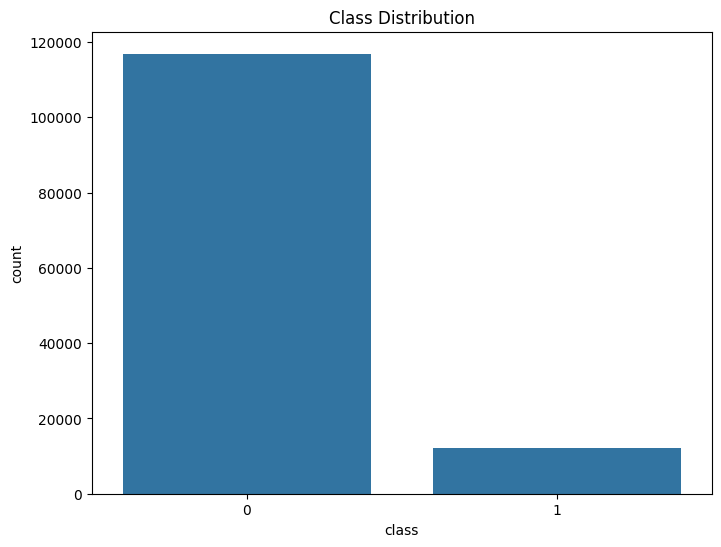

In [3]:
# Visualize Class distribution
class_counts = df['class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

##### Feature-Target Separation and Data Splitting

In [4]:
df['signup_time'] = pd.to_datetime(df['signup_time'], errors='coerce')
df['purchase_time'] = pd.to_datetime(df['purchase_time'], errors='coerce')

print(df['signup_time'].isna().sum(), "NaT values in signup_time")
print(df['purchase_time'].isna().sum(), "NaT values in purchase_time")

# Feature extraction from 'signup_time' and 'purchase_time'
df['signup_year'] = df['signup_time'].dt.year
df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour

df['purchase_year'] = df['purchase_time'].dt.year
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour

# Optionally drop the original datetime columns
X = df.drop(['signup_time', 'purchase_time','user_id','device_id','ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address', 'class'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0 NaT values in signup_time
0 NaT values in purchase_time


##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [5]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


X_train = X_resampled
y_train = y_resampled

In [6]:
# Check the column names of the resampled feature matrix
print(X_train.columns)


Index(['purchase_value', 'sex', 'age', 'time_diff', 'transaction_count',
       'hour_of_day', 'day_of_week', 'purchase_value_scaled', 'source_Direct',
       'source_SEO',
       ...
       'country_Zambia', 'country_Zimbabwe', 'signup_year', 'signup_month',
       'signup_day', 'signup_hour', 'purchase_year', 'purchase_month',
       'purchase_day', 'purchase_hour'],
      dtype='object', length=202)


##### Scaling the Features

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Tracking with MLflow

In [8]:
# Function to log experiments with MLflow
def log_experiment(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


##### Training a Logistic Regression Model

In [9]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_experiment("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
               params={"max_iter": 1000})

2024/10/21 23:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression
Accuracy: 0.8929926442121564, Precision: 0.443447612944569, Recall: 0.5740356698465368, F1 Score: 0.5003615328994938


##### Training a Random forest model

In [10]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "max_depth": 10})

2024/10/21 23:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest
Accuracy: 0.9534649632210608, Precision: 0.9314775160599572, Recall: 0.5412691829116549, F1 Score: 0.6846799580272823


##### Training a Gradient Boosting Model

In [11]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "learning_rate": 0.1})

2024/10/21 23:38:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting
Accuracy: 0.956949283778552, Precision: 0.9992313604919293, Recall: 0.5391953546246371, F1 Score: 0.7004310344827587


##### Training a DecisionTree Model

In [18]:

# Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
log_experiment("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
               params={"max_depth": 5})

[[20453  2966]
 [  959  1452]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     23419
           1       0.33      0.60      0.43      2411

    accuracy                           0.85     25830
   macro avg       0.64      0.74      0.67     25830
weighted avg       0.90      0.85      0.87     25830

Accuracy: 0.8480449090205188
Precision: 0.32865550022634676
Recall: 0.6022397345499793
F1-Score: 0.42524527749304436


In [12]:
import shap
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        
        # SHAP Explanation for tree-based models (Gradient Boosting, Random Forest)
        if model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            
            # In binary classification, shap_values is a matrix, no need to index [1]
            shap.summary_plot(shap_values, X_test, plot_type="bar")
        
        # SHAP Explanation for Logistic Regression (using LinearExplainer)
        elif model_name == "Logistic Regression":
            # Use LinearExplainer for Logistic Regression to reduce memory usage
            explainer = shap.LinearExplainer(model, X_train)
            
            # Subsample the test set for SHAP to handle the memory issue
            #X_test_sample = X_test.sample(100, random_state=42)  # Subsample 100 points
            # Randomly select 100 rows from X_test using NumPy
            X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar")


            print(f"Model: {model_name}")
            print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")



2024/10/21 23:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression
Accuracy: 0.8929926442121564, Precision: 0.443447612944569, Recall: 0.5740356698465368, F1 Score: 0.5003615328994938


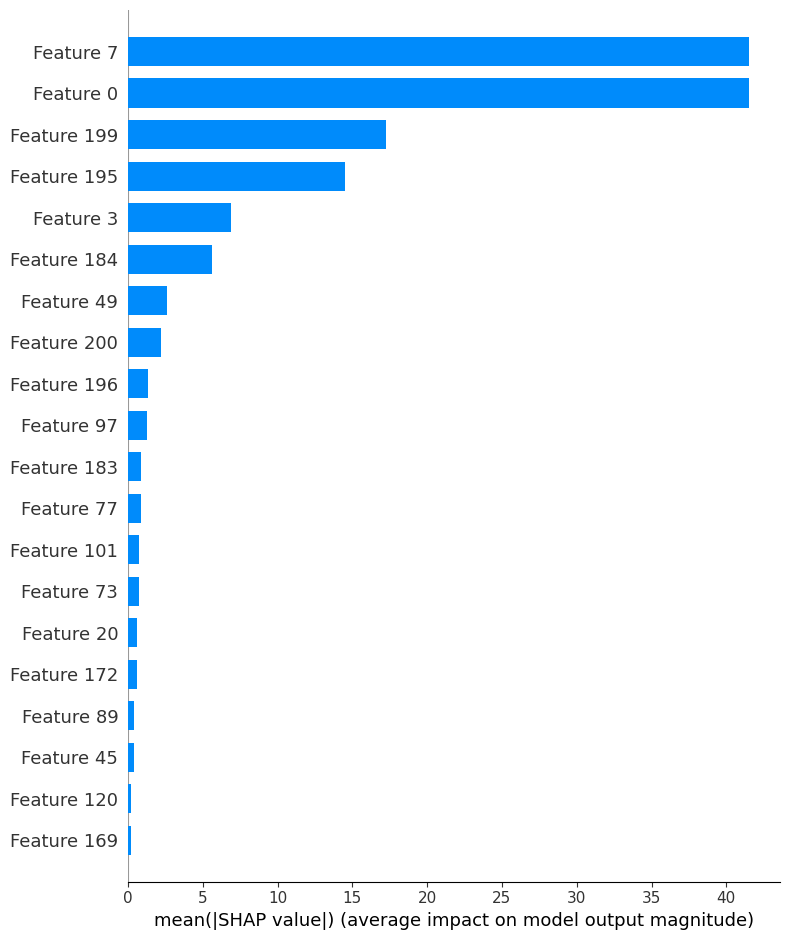

Model: Logistic Regression
Accuracy: 0.8929926442121564, Precision: 0.443447612944569, Recall: 0.5740356698465368, F1 Score: 0.5003615328994938


In [13]:
# Define the models
log_reg = LogisticRegression(max_iter=100)

# Now call the function with each model
log_experiment_with_shap("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
                         params={"max_iter": 100})


2024/10/21 23:39:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree
Accuracy: 0.9229965156794425, Precision: 0.5924627519719544, Recall: 0.5607631688096225, F1 Score: 0.5761772853185596


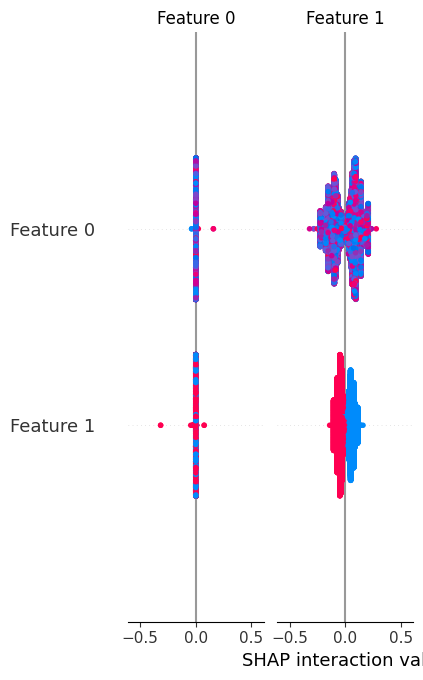

In [14]:
dec_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
log_experiment_with_shap("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
                         params={"max_depth": 10})


2024/10/21 23:40:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest
Accuracy: 0.9534649632210608, Precision: 0.9314775160599572, Recall: 0.5412691829116549, F1 Score: 0.6846799580272823


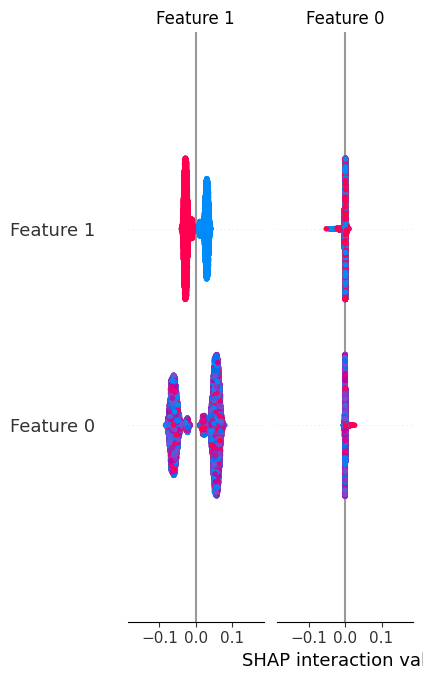

In [15]:
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment_with_shap("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "max_depth": 10})

In [16]:
import shap
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        
        # SHAP Explanation for tree-based models (Gradient Boosting, Random Forest)
        if model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            
            # In binary classification, shap_values is a matrix, no need to index [1]
            shap.summary_plot(shap_values, X_test, plot_type="bar")
        
        # SHAP Explanation for Logistic Regression (using LinearExplainer)
        elif model_name == "Logistic Regression":
            # Use LinearExplainer for Logistic Regression to reduce memory usage
            explainer = shap.LinearExplainer(model, X_train)
            
            # Subsample the test set for SHAP to handle the memory issue
            #X_test_sample = X_test.sample(100, random_state=42)  # Subsample 100 points
            # Randomly select 100 rows from X_test using NumPy
            X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            # Binary classification: using the shap_values for the positive class (class 1)
            shap.summary_plot(shap_values[1], X_test, plot_type="bar")



            print(f"Model: {model_name}")
            print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment_with_shap("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "learning_rate": 0.1})

Lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Function to log experiments with MLflow and add LIME explanation
def log_experiment_with_lime(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        # LIME explanation
        explainer = LimeTabularExplainer(X_train, mode='classification', 
                                         feature_names=X, 
                                         class_names=y, discretize_continuous=True)
        exp = explainer.explain_instance(X_test[0], model.predict_proba, num_features=5)
        exp.show_in_notebook(show_table=True, show_all=False)

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")



In [ ]:
# Now call the function with each model
log_experiment_with_lime("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
                         params={"max_iter": 100})


In [ ]:

log_experiment_with_lime("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
                         params={"max_depth": 5})



In [ ]:
log_experiment_with_lime("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "learning_rate": 0.1})



In [ ]:
log_experiment_with_lime("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "max_depth": 10})
